# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [119]:
# import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes("pastel")
sns.set_style("whitegrid")
%matplotlib inline

from pyspark.sql import SparkSession, Window

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import avg, col, concat, count, desc, asc, explode, lit, split, stddev, udf, isnan, when, rank, from_unixtime

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
# Read in full sparkify dataset
event_data = "../input/mini_sparkify_event_data.json"
df = spark.read.json(event_data)

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

The first five rows of the dataset.

In [4]:
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

Schema information

* artist: Artist name (ex. Daft Punk)
* auth: User authentication status (ex. Logged)
* firstName: User first name (ex. Colin)
* gender: Gender (ex. F or M)
* itemInSession: Item count in a session (ex. 52)
* lastName: User last name (ex. Freeman)
* length: Length of song (ex. 223.60771)
* level: User plan (ex. paid)
* location: User's location (ex. Bakersfield)
* method: HTTP method (ex. PUT)
* page: Page name (ex. NextSong)
* registration: Registration timestamp (unix timestamp) (ex. 1538173362000)
* sessionId: Session ID (ex. 29)
* song: Song (ex. Harder Better Faster Stronger)
* status: HTTP status (ex. 200)
* ts: Event timestamp(unix timestamp) (ex. 1538352676000)
* userAgent: User's browswer agent (ex. Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0)
* userId: User ID (ex. 30)

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## Statistics

Statistics of the whole dataset

In [6]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

Statistics of the `artist` column

In [7]:
df.describe('artist').show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161377|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



Statistics of the `sessionId` column

In [8]:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630807|
|    min|                1|
|    max|             2474|
+-------+-----------------+



Statistics of the `userId` column

In [9]:
df.describe('userId').show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            286500|
|   mean| 59682.02278593872|
| stddev|109091.94999910559|
|    min|                  |
|    max|                99|
+-------+------------------+



Total rows: 286,500

In [10]:
df.count()

286500

All the `page` events

- About: 
- Add Friend: 
- Add to Playlist: 
- Cancel: 
- Cancellation Confirmation: **TODO:**
- Downgrade: 
- Error: 
- Help: 
- Home: 
- Login: 
- Logout: 
- NextSong: 
- Register: 
- Roll Advert: 
- Save Settings: 
- Settings: 
- Submit Downgrade: 
- Submit Registration: 
- Submit Upgrade: 
- Thumbs Down: 
- Thumbs Up: 
- Upgrade: 

`page` kind

In [11]:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



## missing values

In [12]:
def count_missing(df, col):
    """
    A helper function which count how many missing values in a colum of the dataset.
    
    This function is useful because the data can be either three cases below:
    
    1. NaN
    2. Null
    3. "" (empty string)
    """
    return df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "")).count()

Check how many missing values in each column

In [13]:
print("[missing values]\n")
for col in df.columns:
    missing_count = count_missing(df, col)
    if missing_count > 0:
        print("{}: {}".format(col, missing_count))

[missing values]

artist: 58392
firstName: 8346
gender: 8346
lastName: 8346
length: 58392
location: 8346
registration: 8346
song: 58392
userAgent: 8346
userId: 8346


`userId` and `sessionId`

If the below Ids are null or empty, delete those rows:

* userId
* sessionId

In [14]:
df_without_missing_id = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_without_missing_id = df_without_missing_id.filter(df["userId"] != "") # `userId` should not be empty string

In [15]:
print("df:                    {}".format(df.count()))
print("df_without_missing_id: {}".format(df_without_missing_id.count())) # no missing values

if df.count() == df_without_missing_id.count():
    print("No missing values with userId and sessionId")
else:
    print("{} rows have been removed.".format(df.count() - df_without_missing_id.count()))

df:                    286500
df_without_missing_id: 278154
8346 rows have been removed.


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

Detect number columns and category columns.

* num_cols: Number columns (Long or Double)
* cat_cols: Category columns (String)

In [16]:
num_cols = []
cat_cols = []

for s in df.schema:
    data_type = str(s.dataType)
    if data_type == "StringType":
        cat_cols.append(s.name)
    
    if data_type == "LongType" or data_type == "DoubleType":
        num_cols.append(s.name)

In [17]:
num_cols

['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']

In [18]:
cat_cols

['artist',
 'auth',
 'firstName',
 'gender',
 'lastName',
 'level',
 'location',
 'method',
 'page',
 'song',
 'userAgent',
 'userId']

## Number columns

In [19]:
df_without_missing_id.describe(num_cols).show()

+-------+------------------+------------------+--------------------+------------------+------------------+--------------------+
|summary|     itemInSession|            length|        registration|         sessionId|            status|                  ts|
+-------+------------------+------------------+--------------------+------------------+------------------+--------------------+
|  count|            278154|            228108|              278154|            278154|            278154|              278154|
|   mean|114.89918174824018|249.11718197783583|1.535358834085619...|1042.5616241362698|209.10321620397335|1.540958915431790...|
| stddev|129.85172939948959| 99.23517921058313|3.2913216163281236E9| 726.5010362219864|  30.1513888513279|1.5068287123356583E9|
|    min|                 0|           0.78322|       1521380675000|                 1|               200|       1538352117000|
|    max|              1321|        3024.66567|       1543247354000|              2474|               40

There are three HTTP status codes:

* 307: Temporary Redirect
* 404: Not Found
* 200: OK

In [20]:
df_without_missing_id.select("status").dropDuplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



### Category columns

auth

In [21]:
df_without_missing_id.select("auth").dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



gender

In [22]:
df_without_missing_id.select("gender").dropDuplicates().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



level

In [23]:
df_without_missing_id.select("level").dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



location (only showing top 10)

In [24]:
df_without_missing_id.select("location").dropDuplicates().show(10)

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
+--------------------+
only showing top 10 rows



method

In [25]:
df_without_missing_id.select("method").dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



page

In [26]:
df_without_missing_id.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



userAgent (only showing top 10)

In [27]:
df_without_missing_id.select("userAgent").dropDuplicates().show(10)

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 10 rows



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

churn: `Cancellation Confirmation`

In [28]:
df_without_missing_id.filter("page = 'Cancellation Confirmation'").show(10)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

In [29]:
flag_churned_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_churned = df_without_missing_id.withColumn("churned", flag_churned_event("page"))

churned rate (from total event logs)

In [30]:
churned_rate = df_churned.groupby("userId").agg({"churned": "sum"}).select(avg("sum(churned)")).collect()[0]["avg(sum(churned))"]
print("churned: {:.2f}%".format(churned_rate * 100))

churned: 23.11%


In [31]:
df_churned.select(["userId", "gender", "level", "page", "status", "ts", "churned"]).show(30)

+------+------+-----+---------------+------+-------------+-------+
|userId|gender|level|           page|status|           ts|churned|
+------+------+-----+---------------+------+-------------+-------+
|    30|     M| paid|       NextSong|   200|1538352117000|      0|
|     9|     M| free|       NextSong|   200|1538352180000|      0|
|    30|     M| paid|       NextSong|   200|1538352394000|      0|
|     9|     M| free|       NextSong|   200|1538352416000|      0|
|    30|     M| paid|       NextSong|   200|1538352676000|      0|
|     9|     M| free|       NextSong|   200|1538352678000|      0|
|     9|     M| free|       NextSong|   200|1538352886000|      0|
|    30|     M| paid|       NextSong|   200|1538352899000|      0|
|    30|     M| paid|Add to Playlist|   200|1538352905000|      0|
|    30|     M| paid|       NextSong|   200|1538353084000|      0|
|     9|     M| free|       NextSong|   200|1538353146000|      0|
|     9|     M| free|    Roll Advert|   200|1538353150000|    

In [32]:
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df_phase = df_churned.withColumn("phase", Fsum('churned').over(windowval))
df_churn = df_phase.withColumn("churn", Fmax('churned').over(Window.partitionBy("userId")))

In [33]:
df_churn.select(["userId", "gender", "level", "page", "status", "ts", "churned", "phase", "churn"]).show(20)

+------+------+-----+-----------+------+-------------+-------+-----+-----+
|userId|gender|level|       page|status|           ts|churned|phase|churn|
+------+------+-----+-----------+------+-------------+-------+-----+-----+
|100010|     F| free|   NextSong|   200|1539003534000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539003736000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539003932000|      0|    0|    0|
|100010|     F| free|  Thumbs Up|   307|1539003933000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004195000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004511000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004694000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004918000|      0|    0|    0|
|100010|     F| free|Roll Advert|   200|1539004961000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539005157000|      0|    0|    0|
|100010|     F| free|   N

In [34]:
df_churn.filter(df_churn["churn"] == 1).select(["userId", "gender", "level", "page", "status", "ts", "churned", "phase", "churn"]).show(20)

+------+------+-----+--------------------+------+-------------+-------+-----+-----+
|userId|gender|level|                page|status|           ts|churned|phase|churn|
+------+------+-----+--------------------+------+-------------+-------+-----+-----+
|   125|     M| free|            NextSong|   200|1539317144000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539317481000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539317711000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539317914000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318124000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318515000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318728000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318906000|      0|    0|    1|
|   125|     M| free|         Roll Advert|   200|1539318917000|      0|    0

52 userIds were churned

In [35]:
churned_user_count = df_churn.filter(df_churn["churn"] == 1).select("userId").dropDuplicates().count()
print("churned user count: {} (total: {})".format(churned_user_count, df_churn.count()))
print("churned user rate: {:.2f}%".format(churned_user_count / df_churn.count() * 100))

churned user count: 52 (total: 278154)
churned user rate: 0.02%


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

<font color="red">TODO: not yet done</font>

* artist
  * [x] the number of artist
* [x] gender: 0 or 1
* length
  * [x] the total length
* [x] level: 0 or 1
* page
  * [x] the number of `Thumbs Up`
  * [x] the number of `Thumbs Down`
* song
  * [x] the number of song

Define a common function to convert churn value (0 or 1) to `Not Churn` or `Churn`

Both matplotlib and seaborn plot libraries require pandas dataframe, not pyspark dataframe, so I need to convert the pyspark dataframe to pandas one. I do this conversion every time for a small subset of the dataset because if I do this conversion for all the dataset, it takes time and causes an error.

In [151]:
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

In [171]:
df_churn_user = df_churn.groupby("userId").max("churn").withColumnRenamed("max(churn)", "churn").select(["userId", "churn"])

gender

In [149]:
pd_gender = df_churn.select(["userId", "gender", "churn"]).withColumn("churn", func_churn_label("churn")).toPandas()
pd_gender.head()

,userId,gender,churn
0,100010,F,Not Churn
1,100010,F,Not Churn
2,100010,F,Not Churn
3,100010,F,Not Churn
4,100010,F,Not Churn


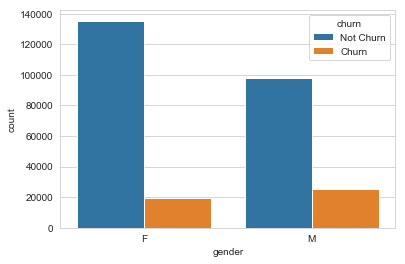

In [150]:
sns.countplot(x="gender", hue="churn", data=pd_gender);

level

In [152]:
pd_level = df_churn.select(["userId", "level", "churn"]).withColumn("churn", func_churn_label("churn")).toPandas()
pd_level.head()

,userId,level,churn
0,100010,free,Not Churn
1,100010,free,Not Churn
2,100010,free,Not Churn
3,100010,free,Not Churn
4,100010,free,Not Churn


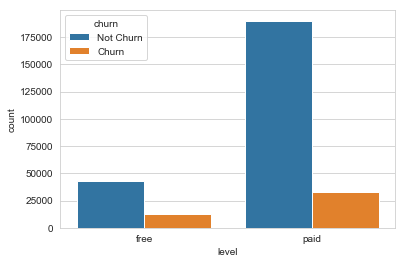

In [153]:
sns.countplot(x="level", hue="churn", data=pd_level);

artist

In [187]:
pd_artist = df_churn_user.join(df_churn.groupby("userId").agg({"artist": "count"}).withColumnRenamed("count(artist)", "artist_count"), ["userId"]).toPandas()
pd_artist.head()

,userId,churn,artist_count
0,100010,0,275
1,200002,0,387
2,125,1,8
3,124,0,4079
4,51,1,2111


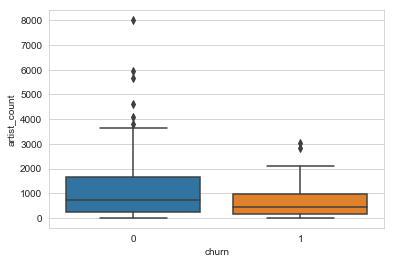

In [188]:
sns.boxplot(x="churn", y="artist_count", data=pd_artist);

song

In [197]:
pd_song = df_churn_user.join(df_churn.groupby("userId").agg({"song": "count"}).withColumnRenamed("count(song)", "song_count"), ["userId"]).toPandas()
pd_song.head()

,userId,churn,song_count
0,100010,0,275
1,200002,0,387
2,125,1,8
3,124,0,4079
4,51,1,2111


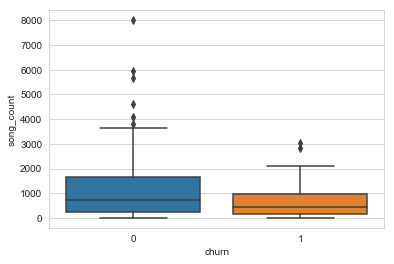

In [198]:
sns.boxplot(x="churn", y="song_count", data=pd_song);

length

In [199]:
pd_length = df_churn_user.join(df_churn.groupby("userId").agg({"length": "sum"}).withColumnRenamed("sum(length)", "total_length"), ["userId"]).toPandas()
pd_length.head()

,userId,churn,total_length
0,100010,0,6.694090e+04
1,200002,0,9.400888e+04
2,125,1,2.089113e+03
3,124,0,1.012312e+06
4,51,1,5.232758e+05


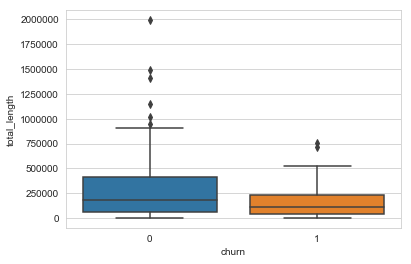

In [200]:
sns.boxplot(x="churn", y="total_length", data=pd_length);

page: total visits

In [185]:
pd_visit = df_churn_user.join(df_churn.groupby("userId").count().withColumnRenamed("count", "visit_count"), ["userId"]).toPandas()
pd_visit.head()

,userId,churn,visit_count
0,100010,0,381
1,200002,0,474
2,125,1,11
3,124,0,4825
4,51,1,2464


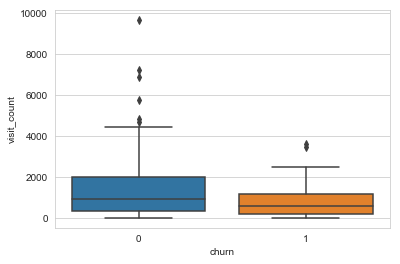

In [186]:
sns.boxplot(x="churn", y="visit_count", data=pd_visit);

page: Thumbs Up / Thumbs Down

up

In [221]:
pd_up = df_churn_user.join(df_churn.filter((df_churn["page"] == 'Thumbs Up')).groupby("userId").count().withColumnRenamed("count", "up_count"), ["userId"]).toPandas()
pd_up.head()

,userId,churn,up_count
0,100010,0,17
1,200002,0,21
2,124,0,171
3,51,1,100
4,7,0,7


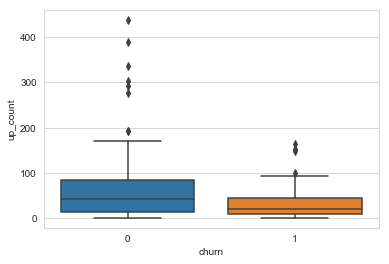

In [222]:
sns.boxplot(x="churn", y="up_count", data=pd_up);

down

In [223]:
pd_down = df_churn_user.join(df_churn.filter((df_churn["page"] == 'Thumbs Down')).groupby("userId").count().withColumnRenamed("count", "down_count"), ["userId"]).toPandas()
pd_down.head()

,userId,churn,down_count
0,100010,0,5
1,200002,0,6
2,124,0,41
3,51,1,21
4,7,0,1


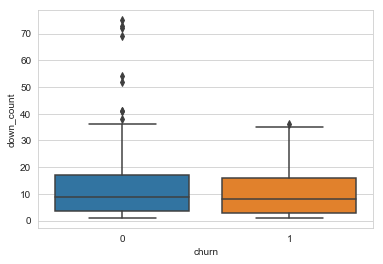

In [224]:
sns.boxplot(x="churn", y="down_count", data=pd_down);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Ideas

* artist
  * [x] the number of artist
* [x] gender: 0 or 1
* length
  * [x] the total length
* [x] level: 0 or 1
* page
  * [x] the number of `Thumbs Up`
  * [x] the number of `Thumbs Down`
* song
  * [x] the number of song
* ts
  * time since registration
  * recent activity count (1 day)
  * recent activity count (1 week)
  * recent activity count (1 month)

In [40]:
df_churn.show(1)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------+-----+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churned|phase|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------+-----+-----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|      0|    0|    0|
+--------------------+---------+----

Original dataframe to be merged later

In [47]:
df_original = df_churn.groupby('userId').max("churn").withColumnRenamed("max(churn)", "target")

In [48]:
df_original.show(10)

+------+------+
|userId|target|
+------+------+
|100010|     0|
|200002|     0|
|   125|     1|
|   124|     0|
|    51|     1|
|     7|     0|
|    15|     0|
|    54|     1|
|   155|     0|
|100014|     1|
+------+------+
only showing top 10 rows



artist count per userId

In [49]:
user_artist = df_churn.groupby("userId").agg({"artist": "count"}).withColumnRenamed("count(artist)", "artist_count")
user_artist.show(5)

+------+------------+
|userId|artist_count|
+------+------------+
|100010|         275|
|200002|         387|
|   125|           8|
|    51|        2111|
|   124|        4079|
+------+------------+
only showing top 5 rows



gender

In [50]:
flag_gender = udf(lambda x: 1 if x == "F" else 0, IntegerType())
df_churn_with_gender = df_churn.withColumn("gender", flag_gender("gender"))
df_churn_with_gender.show(1)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------+-----+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churned|phase|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------+-----+-----+
|Sleeping With Sirens|Logged In| Darianna|     1|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|      0|    0|    0|
+--------------------+---------+----

In [51]:
user_gender = df_churn_with_gender.groupby('userId').agg({"gender": "max"}).withColumnRenamed("max(gender)", "gender")
user_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|100010|     1|
|200002|     0|
|   125|     0|
|    51|     0|
|   124|     1|
+------+------+
only showing top 5 rows



length

In [52]:
user_length = df_churn.groupby('userId').agg({"length": "sum"}).withColumnRenamed("sum(length)", "length")
user_length.show(5)

+------+------------------+
|userId|            length|
+------+------------------+
|100010|       66940.89735|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927900008|
+------+------------------+
only showing top 5 rows



Page

* Thumbs Up
* Thumbs Down

In [53]:
user_thumbs_up = df_churn.filter(df_churn["page"] == 'Thumbs Up').groupby('userId').count().withColumnRenamed("count", "thumb_up")
user_thumbs_up.show(5)

+------+--------+
|userId|thumb_up|
+------+--------+
|100010|      17|
|200002|      21|
|    51|     100|
|   124|     171|
|     7|       7|
+------+--------+
only showing top 5 rows



In [54]:
user_thumbs_down = df_churn.filter(df_churn["page"] == 'Thumbs Down').groupby('userId').count().withColumnRenamed("count", "thumb_down")
user_thumbs_down.show(5)

+------+----------+
|userId|thumb_down|
+------+----------+
|100010|         5|
|200002|         6|
|    51|        21|
|   124|        41|
|     7|         1|
+------+----------+
only showing top 5 rows



level

In [55]:
flag_level = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
df_churn_with_level = df_churn.withColumn("level", flag_level("level"))
df_churn_with_level.show(1)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------+-----+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churned|phase|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------+-----+-----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098|    0|Bridgeport-Stamfo...|   PUT|NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|      0|    0|    0|
+--------------------+---------+----

In [56]:
user_level = df_churn_with_level.groupby('userId').agg({"level": "max"}).withColumnRenamed("max(level)", "level")
user_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    1|
|   125|    0|
|    51|    1|
|   124|    1|
+------+-----+
only showing top 5 rows



song count per userId

In [57]:
user_song = df_churn.groupby("userId").agg({"song": "count"}).withColumnRenamed("count(song)", "song_count")
user_song.show(5)

+------+----------+
|userId|song_count|
+------+----------+
|100010|       275|
|200002|       387|
|   125|         8|
|    51|      2111|
|   124|      4079|
+------+----------+
only showing top 5 rows



<font color="red">TODO: ts</font>

Join all the features

In [58]:
merged_df = df_original.join(user_artist, ['userId']) \
    .join(user_gender, ['userId']) \
    .join(user_length, ['userId']) \
    .join(user_level, ['userId']) \
    .join(user_thumbs_up, ['userId']) \
    .join(user_thumbs_down, ['userId']) \
    .join(user_song, ['userId'])

In [59]:
merged_df.show(5)

+------+------+------------+------+------------------+-----+--------+----------+----------+
|userId|target|artist_count|gender|            length|level|thumb_up|thumb_down|song_count|
+------+------+------------+------+------------------+-----+--------+----------+----------+
|100010|     0|         275|     1|       66940.89735|    0|      17|         5|       275|
|200002|     0|         387|     0| 94008.87593999993|    1|      21|         6|       387|
|   124|     0|        4079|     1|1012312.0927900008|    1|     171|        41|      4079|
|    51|     1|        2111|     0| 523275.8428000004|    1|     100|        21|      2111|
|     7|     0|         150|     0|        38034.0871|    0|       7|         1|       150|
+------+------+------------+------+------------------+-----+--------+----------+----------+
only showing top 5 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Drop `userId` column

In [60]:
merged_df_without_user = merged_df.drop("userId")
feature_columns = [col for col in merged_df_without_user.columns if col!='target']
feature_columns

['artist_count',
 'gender',
 'length',
 'level',
 'thumb_up',
 'thumb_down',
 'song_count']

Train/Test split

In [61]:
train, test = merged_df_without_user.randomSplit([0.7, 0.3], seed=0)

build model

In [62]:
MulticlassClassificationEvaluator?

In [63]:
def build_model(classifier, param):
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='target', metricName='f1'),
        numFolds=5,
    )
    return model

In [64]:
lr = LogisticRegression(featuresCol="scaled_features", labelCol="target")
param = ParamGridBuilder().build()
model = build_model(lr, param)

In [65]:
fit_model = model.fit(train)

In [66]:
pred = fit_model.transform(test)

All the predicted values are 0 (Not churned)

In [69]:
pred.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0)]

Even if the predictions are all 0, f1 score is around 0.73 as a result of the imbalanced dataset.

I've decided to use this score as a baseline and I will try to improve this model.

In [70]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target")
f1_score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
print("f1: {}".format(f1_score))

f1: 0.7324641460234681


### Try different models

Random Forest

In [74]:
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="target")
rf_param = ParamGridBuilder().build()
rf_model = build_model(rf, rf_param)

In [76]:
rf_fit_model = rf_model.fit(train)

In [77]:
rf_pred = rf_fit_model.transform(test)

In [78]:
rf_pred.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

In [80]:
rf_f1_score = evaluator.evaluate(rf_pred, {evaluator.metricName: "f1"})
print("f1: {}".format(rf_f1_score))

f1: 0.7757085020242915


GBT

In [82]:
gbt =GBTClassifier(featuresCol="scaled_features", labelCol="target")
gbt_param = ParamGridBuilder().build()
gbt_model = build_model(gbt, gbt_param)

In [83]:
gbt_fit_model = gbt_model.fit(train)

In [84]:
gbt_pred = gbt_fit_model.transform(test)

In [85]:
gbt_pred.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

In [86]:
gbt_f1_score = evaluator.evaluate(gbt_pred, {evaluator.metricName: "f1"})
print("f1: {}".format(gbt_f1_score))

f1: 0.7215309200603317


### Feature Importances

Random Forest

In [121]:
rf_feature_importance_df = pd.DataFrame()
rf_feature_importance_df['feature'] = feature_columns
rf_feature_importance_df['importance'] = rf_fit_model.bestModel.stages[2].featureImportances.values.tolist()
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
rf_feature_importance_df

,feature,importance
0,thumb_down,0.223848
1,thumb_up,0.219722
2,artist_count,0.190366
3,song_count,0.170799
4,gender,0.088382
5,length,0.080555
6,level,0.026328


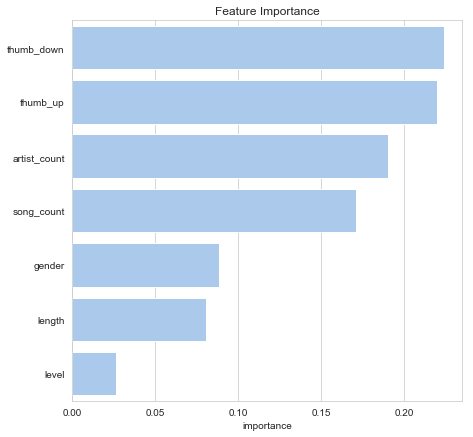

In [120]:
plt.figure(figsize=(7,7))
sns.barplot(x='importance', y='feature', data=rf_feature_importance_df, color="b")
plt.title('Feature Importance')
plt.ylabel('');

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.